In [211]:
# %matplotlib ipympl
import scipy.signal as signal
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import RectangleSelector
import skimage.util
import scipy.ndimage as ndimage
from skimage.color import rgb2gray
from skimage.morphology import disk
from skimage.io import imread
import matplotlib
import skimage.restoration as restoration

import skimage.filters.rank as rank
plt.gray()
def PSNR(f,g):
    return 10*np.log10(1.0/ np.mean(np.square(f-g)))


class Selector:
    def __init__(self, ax):
        self.RS = RectangleSelector(ax, self.line_select_callback,
                                     useblit=True,
                                       button=[1, 3],  
                                       minspanx=5, minspany=5,
                                       spancoords='pixels',
                                       interactive=True)
        self.bbox = [None, None, None, None]
        
    def line_select_callback(self,eclick, erelease):
        'eclick and erelease are the press and release events'
        x1, y1 = eclick.xdata, eclick.ydata
        x2, y2 = erelease.xdata, erelease.ydata
        self.bbox = [int(y1), int(y2), int(x1), int(x2)]
    def get_bbox(self):
        return self.bbox

f = imread('cameraman.tif').astype(np.float64)/255
I = imread('degraded.tif').astype(np.float64)/255


<Figure size 640x480 with 0 Axes>

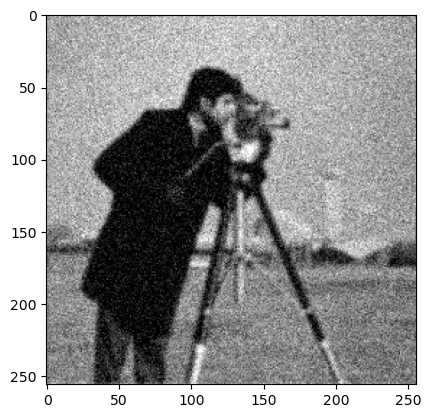

In [212]:
plt.imshow(I)
plt.show()

## 2 Image Restoration in The Frequency Domain

In [213]:
# Creates disk filter to apply in Fourier domain
h_d = disk(4)
h = np.zeros((256,256))
h[0:9,0:9] = h_d
h = np.roll(h, (-5,-5)) / np.sum(h)
h_freq = np.fft.fft2(h)
f_blurfreq = h_freq*np.fft.fft2(f)
f_blur = np.real(np.fft.ifft2(f_blurfreq))

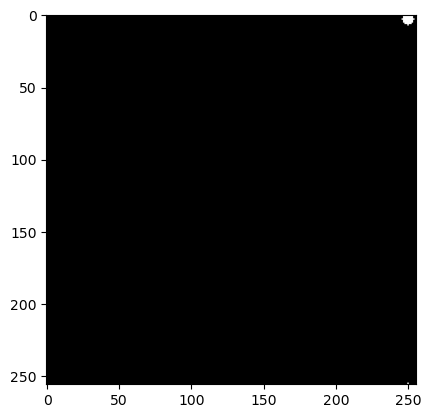

In [214]:
plt.imshow(h)
plt.show()

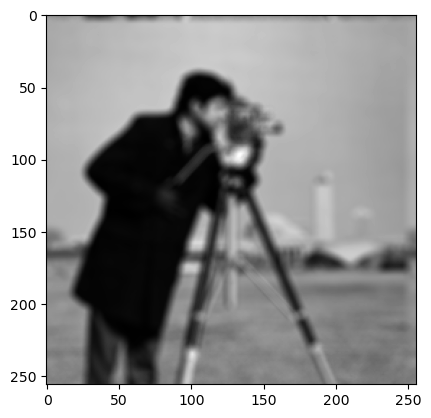

In [215]:
plt.imshow(f_blur)
plt.show()

In [216]:
print("PSNR of blurred image:", PSNR(f_blur, f))

PSNR of blurred image: 16.313347655863858


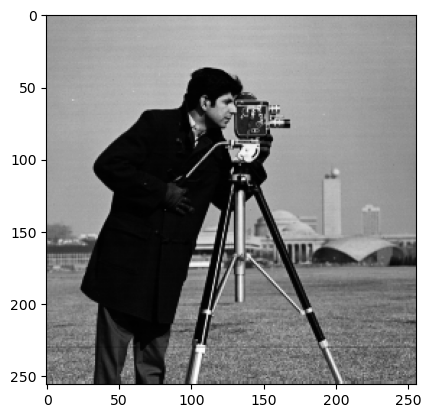

In [217]:
f_restorefreq = f_blurfreq / h_freq
f_restore = np.real(np.fft.ifft2(f_restorefreq))
plt.imshow(f_restore)
plt.show()

In [218]:
from skimage.util import random_noise
# 2 and 3
f_blur_gaussian = random_noise(f_blur, var=0.002)

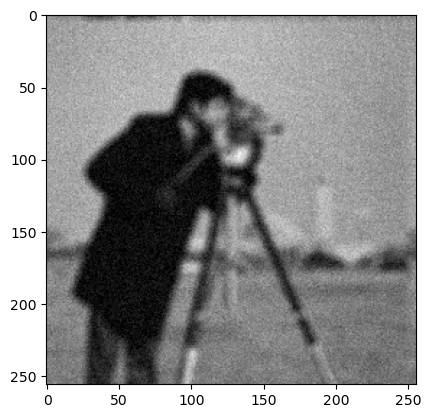

In [219]:
plt.imshow(f_blur_gaussian)
plt.show()

In [ ]:
f_blur_gaussian_freq = np.fft.fft2(f_blur_gaussian)
f_restore_gaussian_freq = f_blur_gaussian_freq / h_freq
f_restore_gaussian = np.real(np.fft.ifft2(f_restore_gaussian_freq))
f_restore_gaussian = f_restore_gaussian
print(np.abs(h_freq).min())

4.8975879992650736e-06


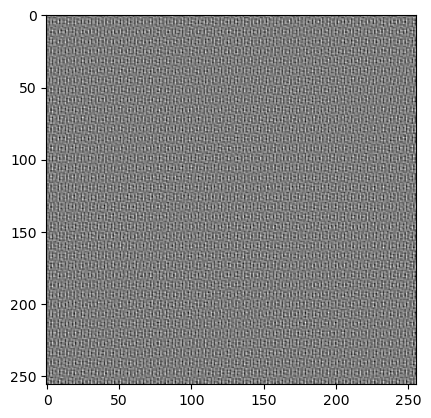

In [221]:
plt.imshow(f_restore_gaussian)
plt.show()

In [ ]:
print("PSNR of blurred image:", PSNR(f_blur_gaussian, f_restore_gaussian / np.sum(f_restore_gaussian)))

PSNR of blurred image: 46.46971024397545


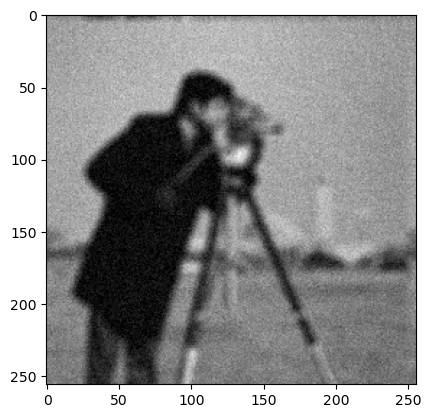

In [223]:
plt.imshow(f_blur_gaussian)
plt.show()

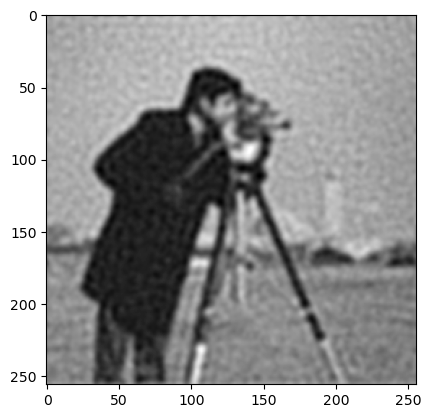

In [224]:
# 4 and 5
# centered_h_freq = np.fft.fftshift(h_freq)
# centered_f_blur_gaussian_freq = np.fft.fftshift(f_blur_gaussian)

NSR = 0.1

weiner_restored_h = restoration.wiener(f_blur_gaussian, np.fft.fftshift(h), balance=NSR)
plt.imshow(np.real(weiner_restored_h))
plt.show()

In [225]:
PSNR(weiner_restored_h, f)

22.69786387419679

# 3 - Adaptive Filtering

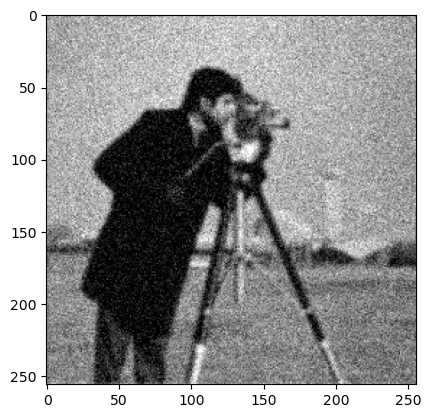

In [226]:
plt.imshow(I, vmax=1, vmin=0)
plt.show()

In [227]:
mn = np.ones((5,5))/25
local_mean = signal.convolve(I, mn, mode='same')
local_var = signal.convolve(I**2, mn, mode='same') - local_mean**2

In [228]:
bbox = [6, 91, 171, 250]
bbox_area = I[bbox[0]:bbox[1],bbox[2]:bbox[3]]
print(bbox_area)
noise_var = np.var(bbox_area)
print(noise_var)

[[0.69803922 0.80392157 0.76078431 ... 0.61176471 0.61568627 0.51764706]
 [0.78039216 0.6627451  0.8627451  ... 0.86666667 0.6627451  0.7372549 ]
 [0.70196078 0.71764706 0.84705882 ... 0.69019608 0.61176471 0.72156863]
 ...
 [0.6        0.76078431 0.76470588 ... 0.58431373 0.58823529 0.51764706]
 [0.70980392 0.80392157 0.57254902 ... 0.68627451 0.41568627 0.61568627]
 [0.77647059 0.65490196 0.70980392 ... 0.47058824 0.63137255 0.54509804]]
0.010926343981434779


In [229]:
K = (local_var - noise_var) / local_var
K

array([[ 0.86848488,  0.88697841,  0.88329542, ...,  0.89124616,
         0.89550223,  0.88185933],
       [ 0.87107944,  0.87266065,  0.82650204, ...,  0.84129022,
         0.88576863,  0.89183869],
       [ 0.87678817,  0.84093832, -0.38626343, ...,  0.08647143,
         0.8525051 ,  0.89848267],
       ...,
       [ 0.82947557,  0.78523699,  0.25706299, ..., -0.27008131,
         0.76788728,  0.84093593],
       [ 0.84057798,  0.83708729,  0.79985205, ...,  0.76433486,
         0.82720943,  0.84198083],
       [ 0.83023507,  0.85297529,  0.86315157, ...,  0.82411329,
         0.82540951,  0.80653238]])

In [230]:
lee_output = K * I + (1 - K) * local_mean

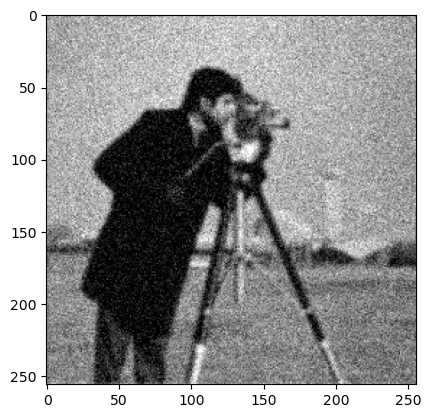

In [231]:
plt.imshow(I, vmin=0, vmax=1)

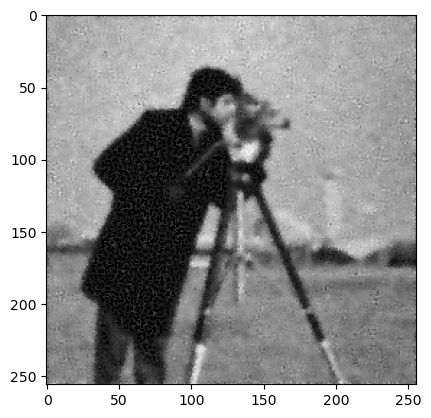

In [232]:
plt.imshow(lee_output, vmin=0, vmax=1)

### Varying parameters for Lee filter

In [233]:
varied_noise_up = noise_var * 1.5 # increase by 50%
varied_noise_down = noise_var * 0.5 # decrease by 50%

In [234]:
# recompute K
K_up = (local_var - varied_noise_up) / local_var
K_down = (local_var - varied_noise_down) / local_var

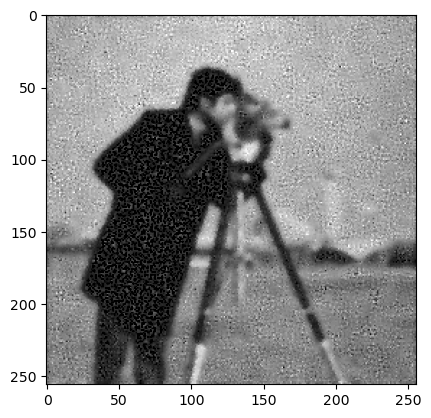

In [235]:
lee_output_up = K_up * I + (1 - K_up) * local_mean
plt.imshow(lee_output_up, vmin=0, vmax=1)
plt.show()

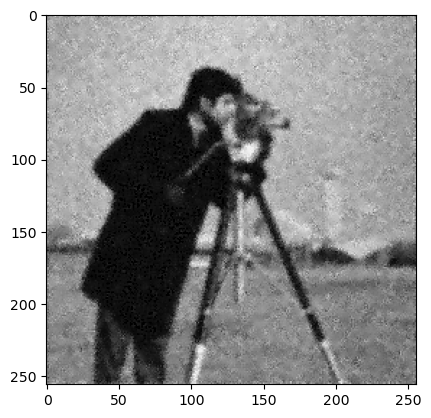

In [236]:
lee_output_down = K_down * I + (1 - K_down) * local_mean
plt.imshow(lee_output_down, vmin=0, vmax=1)
PSNR(lee_output_down, I)
plt.show()

In [237]:
def gaussian_filter(n_rows, n_cols, stdv):
    """
    Returns a 2d Gaussian image filter.
    """
    g_r = signal.windows.gaussian(n_rows, stdv)
    g_c = signal.windows.gaussian(n_cols, stdv)

    G = np.outer(g_r, g_c)

    return G/np.max(G)

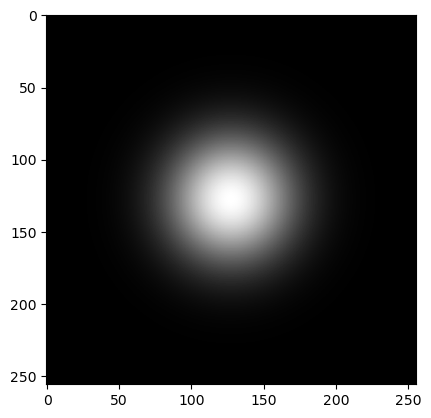

In [238]:
gaussian_lp = gaussian_filter(*np.shape(lee_output), 30)
plt.imshow(gaussian_lp)

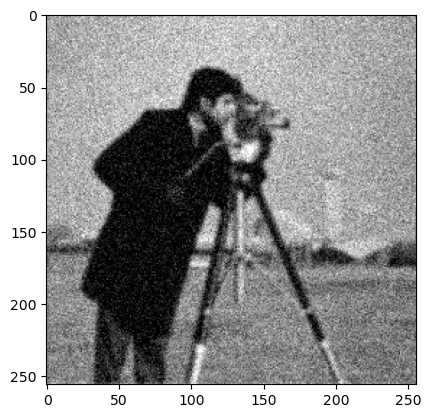

In [239]:
plt.imshow(I)

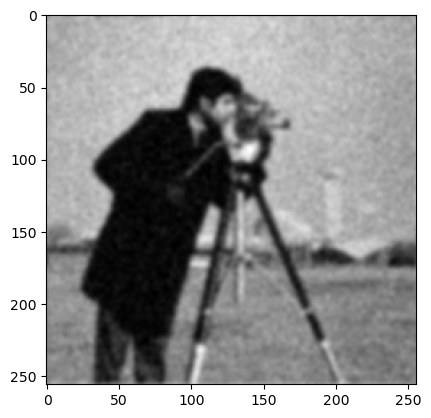

In [240]:
I_freq = np.fft.fftshift(np.fft.fft2(I))
I_freq_gaussian = I_freq * gaussian_lp
I_gaussian = np.fft.ifft2(np.fft.ifftshift(I_freq_gaussian))
plt.imshow(np.abs(I_gaussian))